In [2]:
import numpy as np
from scipy.integrate import cumulative_trapezoid
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams.update({'font.size': 18})

# Create a simple signal with two frequencies
dt = 0.005*1           # this is the frequency, in LJ units of time, of saving the data
N = 256                # number of particles         
MT = 2048             # max number of confs per block
MB = 24                 # max number of blocks
# 2**11=2048
# 2**12=4096
# 2**14=16384
# 2**15=32768
# if we want to avoid aliasing we need to fill with zero up to 20000 which means 32768
# Define the number of columns in your data
num_columns = 7  # Adjust to match the number of columns in your data
# Initialize empty lists to store the data for each column
data_columns = [[] for _ in range(num_columns-1)]
rpos=np.zeros((MB, 2**12, N, 3))
vel=np.zeros((MB, 2**12, N, 3))


with open('../WORK/NVE_MD/trajectory.xyz') as fdat:
    count_global=0
    count = 0
    block = 0
    nparts = int(fdat.readline())
    while nparts != '' and count_global < MT*MB :
        nparts = int(nparts)
        count_global += 1
        count += 1
        if (count == MT) :
            block += 1
            count = 0
            print('finish reading block',block-1,count_global)
#       while (block < MB):
        box = [ float(value) for value in fdat.readline().split() ]
        for ind in range(nparts):
            rpos[block-1, count-1, ind,0], rpos[block-1, count-1, ind,1], rpos[block-1, count-1, ind,2], \
            vel[block-1, count-1, ind, 0], vel[block-1, count-1, ind, 1], vel[block-1, count-1, ind, 2] = \
            [float(value) for value in fdat.readline().split()[1:]]            
                
        nparts = fdat.readline()

finish reading block 0 2048
finish reading block 1 4096
finish reading block 2 6144
finish reading block 3 8192
finish reading block 4 10240
finish reading block 5 12288
finish reading block 6 14336
finish reading block 7 16384
finish reading block 8 18432
finish reading block 9 20480
finish reading block 10 22528
finish reading block 11 24576
finish reading block 12 26624
finish reading block 13 28672
finish reading block 14 30720
finish reading block 15 32768
finish reading block 16 34816
finish reading block 17 36864
finish reading block 18 38912
finish reading block 19 40960
finish reading block 20 43008
finish reading block 21 45056
finish reading block 22 47104
finish reading block 23 49152


In [3]:
## Compute the Fast Fourier Transform (FFT)
time=np.zeros(2**12)
for i in range(2**12):
    time[i]=i*dt
print(time)

[0.0000e+00 5.0000e-03 1.0000e-02 ... 2.0465e+01 2.0470e+01 2.0475e+01]


In [4]:
nt = len(time)
fhat = np.zeros((nt))
cvv = np.zeros((nt))
cvv2 = np.zeros((nt))
kubo = np.zeros((nt))
kubo2 = np.zeros((nt))
nparts = int(nparts)

for nb in range(MB):
    for i in range(nparts):
        for k in range(3):
            fhat = np.fft.fft(vel[nb,:,i,k],nt)           # Compute the FFT
            PSD = fhat * np.conj(fhat) / (nt/2.)                      # Power spectrum (power per freq)
            cvv += np.real(np.fft.ifft(PSD))
            cvv2 += np.real(np.fft.ifft(PSD))**2
            kubo += cumulative_trapezoid(np.real(np.fft.ifft(PSD)), x=time, initial=0)
            kubo2 += (cumulative_trapezoid(np.real(np.fft.ifft(PSD)), x=time, initial=0))**2
#freq = (1/(dt*nt)) * np.arange(nt)           # Create x-axis of frequencies in Hz
#L = np.arange(1,np.floor(nt/2),dtype='int') # Only plot the first half of freqs
cvv /= (3.*nparts*MB)
cvv2 /= (3.*nparts*MB)
cvv2 = np.sqrt((cvv2-cvv**2)/(3.*nparts*MB))
kubo /= (3.*nparts*MB)
kubo2 /= (3.*nparts*MB)
kubo2 = np.sqrt((kubo2-kubo**2)/(3.*nparts*MB))

In [6]:
# reading the diffusion.out file
ttt = np.zeros((nt))
cvv_stnd = np.zeros((nt))
kubo_int = np.zeros((nt))
num_col = 3
data_columns = [[] for _ in range(num_col)]
with open('../WORK/NVE_MD/diffusion.out') as fdat:
    for line_number, line in enumerate(fdat):
        #fields = line.strip().split()
        ttt[line_number], cvv_stnd[line_number], kubo_int[line_number] = [float(value) for value in line.strip().split()[:3]] 

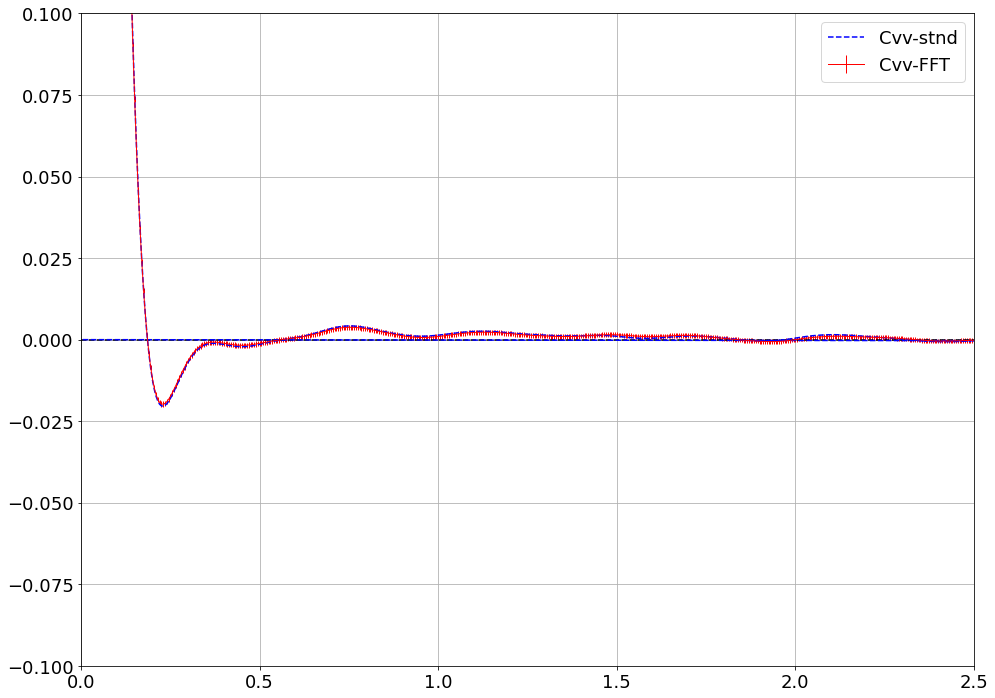

In [8]:
## Plots
fig,axs = plt.subplots(1,1)

#plt.sca(axs[0])
horizontal_line_value = 0
plt.errorbar(time,cvv,cvv2, color='r',linewidth=1,linestyle='solid',label='Cvv-FFT')
plt.axhline(y=horizontal_line_value, color='k', linestyle='--')
plt.plot(ttt,cvv_stnd/3.,color='b',linestyle='dashed',label='Cvv-stnd')
plt.xlim(time[0],time[500])
plt.ylim(-0.1,0.1)
plt.grid()
plt.legend()

#plt.sca(axs[1])
#plt.plot(t,cvvint-kubo,color='r',linewidth=1.5,label='Dr.v')
#plt.plot(t,kubo,color='b',linewidth=1.5,label='Kubo')
#plt.xlim(time[0],time[-1])
#plt.legend()

#plt.sca(axs[2])
#plt.yscale('log')
#plt.plot(t,cvvint,color='r',linewidth=1.5,label='Kubo')
#plt.plot(t,msd,color='b',linewidth=1.5,label='MSD')
#plt.xlim(time[0],time[-1])
#plt.legend()

plt.show()

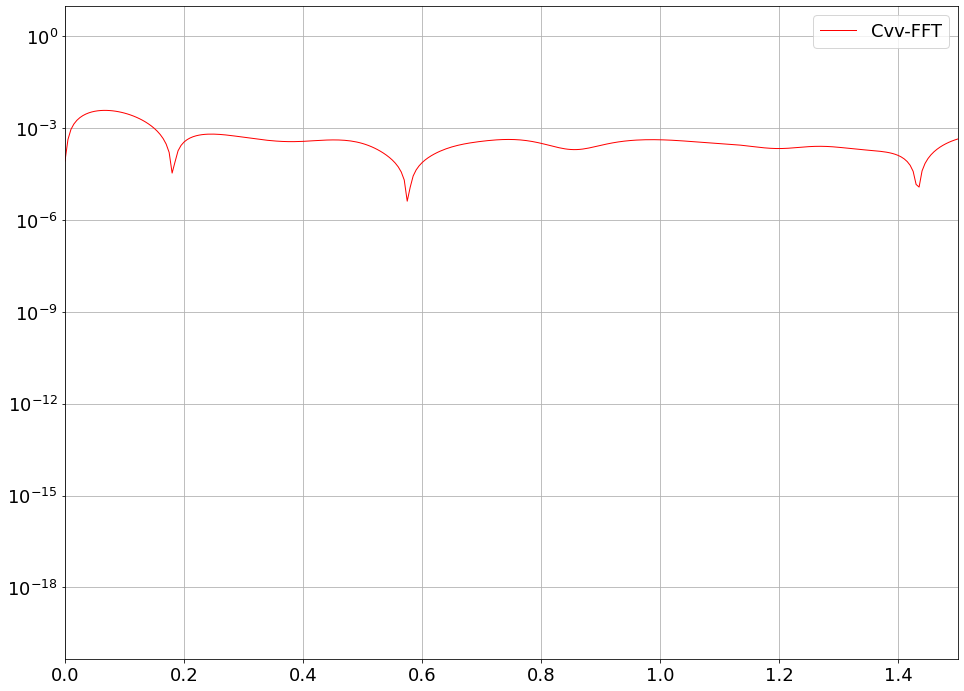

In [9]:
## Plots
plt.semilogy(time,np.abs(cvv-cvv_stnd/3.), color='r',linewidth=1,linestyle='solid',label='Cvv-FFT')
#plt.plot(ttt,cvv_stnd/3.,color='b',linestyle='dashed',label='Cvv-stnd')
plt.xlim(time[0],time[300])
plt.grid()
plt.legend()
plt.show()

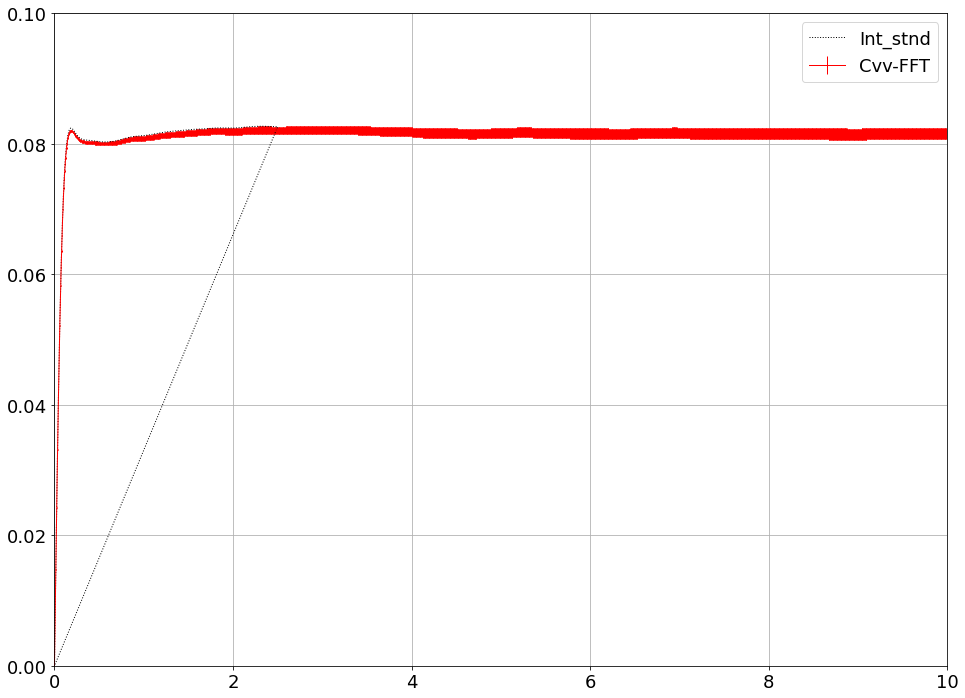

In [10]:
## Plots
plt.errorbar(time,kubo,kubo2,color='r',linewidth=1,linestyle='solid',label='Cvv-FFT')
plt.plot(ttt,kubo_int/3., color='k',linewidth=1,linestyle='dotted',label='Int_stnd')
#plt.plot(ttt,cvv_stnd/3.,color='b',linestyle='dashed',label='Cvv-stnd')
plt.xlim(time[0],time[2000])
plt.ylim(0,0.1)
plt.grid()
plt.legend()
plt.show()